In [1]:
from __future__ import division, print_function
import sympy as sm
import sympy.physics.mechanics as me
me.init_vprinting()

Now specify the number of links, $n$. I'll start with 5 since the Wolfram folks only showed four.

In [2]:
n = 1
do_sim = False
do_plot = False

**mechanics** will need the generalized coordinates, generalized speeds, and the input force which are all time dependent variables and the bob masses, link lengths, and acceleration due to gravity which are all constants. Time, $t$, is also made available because we will need to differentiate with respect to time.

In [3]:
import numpy as np
q = me.dynamicsymbols('q:{}'.format(n + 1))  # Generalized coordinates
u = me.dynamicsymbols('dq:{}'.format(n + 1))  # Generalized speeds
f = me.dynamicsymbols('f:{}'.format(n))      # Force applied to the cart
    
# m = sm.symbols('m:{}'.format(n + 1))         # Mass of each bob
# l = sm.symbols('l:{}'.format(n))             # Length of each link

m = (0.01 / n)*np.ones(n+1,)
l = (1. / n)*np.ones(n+1,)
g = 9.81
t = sm.symbols('t')                     # Gravity and time

Now we can create and inertial reference frame $I$ and define the point, $O$, as the origin.

In [4]:
I = me.ReferenceFrame('I')  # Inertial reference frame
O = me.Point('O')           # Origin point
O.set_vel(I, 0)             # Origin's velocity is zero

Secondly, we define the define the first point of the pendulum as a particle which has mass. This point can only move laterally and represents the motion of the "cart".

In [5]:
P0 = me.Point('P0')                 # Hinge point of top link
P0.set_pos(O, q[0] * I.x)           # Set the position of P0    
P0.set_vel(I, u[0] * I.x)           # Set the velocity of P0
Pa0 = me.Particle('Pa0', P0, m[0])  # Define a particle at P0

Now we can define the $n$ reference frames, particles, gravitational forces, and kinematical differential equations for each of the pendulum links. This is easily done with a loop.

In [6]:
frames = [I]                              # List to hold the n + 1 frames
points = [P0]                             # List to hold the n + 1 points
particles = [Pa0]                         # List to hold the n + 1 particles
forces = [(P0, f[0] * I.x - m[0] * g * I.y)] # List to hold the n + 1 applied forces, including the input force, f
kindiffs = [q[0].diff(t) - u[0]]          # List to hold kinematic ODE's

for i in range(n):
    Bi = I.orientnew('B' + str(i), 'Axis', [q[i + 1], I.z])   # Create a new frame
    Bi.set_ang_vel(I, u[i + 1] * I.z)                         # Set angular velocity
    frames.append(Bi)                                         # Add it to the frames list

    Pi = points[-1].locatenew('P' + str(i + 1), l[i] * Bi.x)  # Create a new point
    Pi.v2pt_theory(points[-1], I, Bi)                         # Set the velocity
    points.append(Pi)                                         # Add it to the points list
    
    Pai = me.Particle('Pa' + str(i + 1), Pi, m[i + 1])        # Create a new particle
    particles.append(Pai)                                     # Add it to the particles list

    forces.append((Pi, -m[i + 1] * g * I.y))                  # Set the force applied at the point
    kindiffs.append(q[i + 1].diff(t) - u[i + 1])              # Define the kinematic ODE:  dq_i / dt - u_i = 0
for i in range(n-1):
    forces.append((frames[i+1], f[i+1]*frames[i].z))

With all of the necessary point velocities and particle masses defined, the `KanesMethod` class can be used to derive the equations of motion of the system automatically.

In [7]:
forces

[(P0, f0*I.x - 0.0981000000000000*I.y), (P1, - 0.0981000000000000*I.y)]

In [8]:
kane = me.KanesMethod(I, q_ind=q, u_ind=u, kd_eqs=kindiffs)  # Initialize the object
fr, frstar = kane.kanes_equations(forces, particles)         # Generate EoM's fr + frstar = 0

/Users/shenshen/veril/ENV/lib/python3.7/site-packages/sympy/physics/mechanics/kane.py:536: SymPyDeprecationWarning: 

The kanes_equation() argument order has been deprecated since SymPy
1.1. Use switched argument order to update your code, For example:
kanes_equations(loads, bodies) > kanes_equations(bodies, loads).
instead. See https://github.com/sympy/sympy/issues/10945 for more
info.  The API for kanes_equations() has changed such that the loads
(forces and torques) are now the second argument and is optional with
None being the default.

  issue=10945, deprecated_since_version="1.1").warn()


The equations of motion are quite long as can been seen below. This is the general nature of most non-simple mutlibody problems. That is why a SymPy is so useful; no more mistakes in algebra, differentiation, or copying hand written equations. Note that `trigsimp` can take quite a while to complete for extremely large expressions. Below we print $\tilde{M}$ and $\tilde{f}$ from $\tilde{M}\dot{u}=\tilde{f}$ to show the size of the expressions.

In [9]:
# sm.trigsimp(kane.mass_matrix)

$\tilde{M}$ is a function of the constant parameters and the configuration.

In [10]:
# me.find_dynamicsymbols(kane.mass_matrix)

In [11]:
# sm.trigsimp(kane.forcing)

$\tilde{f}$ is a function of the constant parameters, configuration, speeds, and the applied force.

In [12]:
# me.find_dynamicsymbols(kane.forcing)

Simulation
==========

Now that the symbolic equations of motion are available we can simulate the pendulum's motion. We will need some more SymPy functionality and several NumPy functions, and most importantly the integration function from SciPy, `odeint`.

In [13]:
import numpy as np
from numpy.linalg import solve
from scipy.integrate import odeint

First, define some numeric values for all of the constant parameters in the problem.

In [14]:
arm_length = 1. / n                          # The maximum length of the pendulum is 1 meter
bob_mass = 0.01 / n                          # The maximum mass of the bobs is 10 grams
parameters = [g, m[0]]                       # Parameter definitions starting with gravity and the first bob
parameter_vals = [9.81, 0.01 / n]            # Numerical values for the first two
for i in range(n):                           # Then each mass and length
    parameters += [l[i], m[i + 1]]            
    parameter_vals += [arm_length, bob_mass]

Mathematica has a really nice `NDSolve` function for quickly integrating their symbolic differential equations. We make use of SymPy's lambdify function to do something similar, i.e. to create functions that will evaluate the "full" mass matrix, $M$, and "full" forcing vector, $f$ from $M\dot{x} = f(x, r, t)$ as a NumPy function.

In [15]:
dynamic = q + u +f   # Make a list of the states
# dynamic.append(f)  # Add the input force
print(len(dynamic))
M_func = sm.lambdify(dynamic, kane.mass_matrix_full) # Create a callable function to evaluate the mass matrix 
f_func = sm.lambdify(dynamic, kane.forcing_full)     # Create a callable function to evaluate the forcing vector 

5


To integrate the ODE's we need to define a function that returns the derivatives of the states given the current state and time.

In [16]:
def right_hand_side(x, t, args):
    """Returns the derivatives of the states.

    Parameters
    ----------
    x : ndarray, shape(2 * (n + 1))
        The current state vector.
    t : float
        The current time.
    args : ndarray
        The constants.

    Returns
    -------
    dx : ndarray, shape(2 * (n + 1))
        The derivative of the state.
    
    """
    r = np.zeros(n,)                                  # The input force is always zero     
    arguments = np.hstack((x, r))      # States, input, and parameters
    dx = np.array(solve(M_func(*arguments),  # Solving for the derivatives
                  f_func(*arguments))).T[0]
    
    return dx

Now that we have the right hand side function, the initial conditions are set such that the pendulum is in the vertical equilibrium and a slight initial rate is set for each speed to ensure the pendulum falls. The equations can then be integrated with SciPy's `odeint` function given a time series.

In [17]:
if do_plot:
    x0 = np.hstack((0.0,                              # q0
                np.pi / 2 * np.ones(len(q) - 1),  # q1...qn+1
                1e-3 * np.ones(len(u))))          # u0...un+1
    t = np.linspace(0.0, 10.0, num=500)  # Time vector
    x = odeint(right_hand_side, x0, t, args=(parameter_vals,))  # Numerical integration

Plotting
========

The results of the simulation can be plotted with matplotlib. First, load the plotting functionality.

In [18]:
import matplotlib.pyplot as plt

In [19]:
%matplotlib inline

In [20]:
from IPython.core.pylabtools import figsize
figsize(8.0, 6.0)

The coordinate trajectories are plotted below.

In [21]:
if do_plot:
    lines = plt.plot(t, x[:, :x.shape[1] // 2])
    lab = plt.xlabel('Time [sec]')
    leg = plt.legend(dynamic[:x.shape[1] // 2])

And the generalized speed trajectories.

In [22]:
if do_plot:
    lines = plt.plot(t, x[:, x.shape[1] // 2:])
    lab = plt.xlabel('Time [sec]')
    leg = plt.legend(dynamic[x.shape[1] // 2:])

Animation
=========

matplotlib now includes very nice animation functions for animating matplotlib plots. First we import the necessary functions for creating the animation.

In [23]:
from matplotlib import animation
from matplotlib.patches import Rectangle

The following function was modeled from Jake Vanderplas's [post on matplotlib animations](http://jakevdp.github.com/blog/2012/08/18/matplotlib-animation-tutorial/). The default animation writer is used (typically ffmpeg), you can change it by adding `writer` argument to `anim.save` call.

In [24]:
def animate_pendulum(t, states, length, filename=None):
    """Animates the n-pendulum and optionally saves it to file.

    Parameters
    ----------
    t : ndarray, shape(m)
        Time array.
    states: ndarray, shape(m,p)
        State time history.
    length: float
        The length of the pendulum links.
    filename: string or None, optional
        If true a movie file will be saved of the animation. This may take some time.

    Returns
    -------
    fig : matplotlib.Figure
        The figure.
    anim : matplotlib.FuncAnimation
        The animation.

    """
    # the number of pendulum bobs
    numpoints = states.shape[1] // 2

    # first set up the figure, the axis, and the plot elements we want to animate
    fig = plt.figure()
    
    # some dimesions
    cart_width = 0.4
    cart_height = 0.2
    
    # set the limits based on the motion
    xmin = np.around(states[:, 0].min() - cart_width / 2.0, 1)
    xmax = np.around(states[:, 0].max() + cart_width / 2.0, 1)
    
    # create the axes
    ax = plt.axes(xlim=(xmin, xmax), ylim=(-1.1, 1.1), aspect='equal')
    
    # display the current time
    time_text = ax.text(0.04, 0.9, '', transform=ax.transAxes)
    
    # create a rectangular cart
    rect = Rectangle([states[0, 0] - cart_width / 2.0, -cart_height / 2],
                     cart_width, cart_height, fill=True, color='red',
                     ec='black')
    ax.add_patch(rect)
    
    # blank line for the pendulum
    line, = ax.plot([], [], lw=2, marker='o', markersize=6)

    # initialization function: plot the background of each frame
    def init():
        time_text.set_text('')
        rect.set_xy((0.0, 0.0))
        line.set_data([], [])
        return time_text, rect, line,

    # animation function: update the objects
    def animate(i):
        time_text.set_text('time = {:2.2f}'.format(t[i]))
        rect.set_xy((states[i, 0] - cart_width / 2.0, -cart_height / 2))
        x = np.hstack((states[i, 0], np.zeros((numpoints - 1))))
        y = np.zeros((numpoints))
        for j in np.arange(1, numpoints):
            x[j] = x[j - 1] + length * np.cos(states[i, j])
            y[j] = y[j - 1] + length * np.sin(states[i, j])
        line.set_data(x, y)
        return time_text, rect, line,

    # call the animator function
    anim = animation.FuncAnimation(fig, animate, frames=len(t), init_func=init,
            interval=t[-1] / len(t) * 1000, blit=True, repeat=False)
    
    # save the animation if a filename is given
    if filename is not None:
        anim.save(filename, fps=30, codec='libx264')
    return anim

Now we can create the animation of the pendulum. This animation will show the open loop dynamics.

In [25]:
if do_sim:
    anim = animate_pendulum(t, x, arm_length)

# Set up formatting for the movie files
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

    anim.save('open-loop.mp4',writer = 'ffmpeg')

In [26]:
if do_sim:
    from IPython.display import HTML
    html = \
    """
    <video width="640" height="480" controls>
      <source src="open-loop.mp4" type="video/mp4">
    Your browser does not support the video tag, check out the YouTube version instead: http://youtu.be/Nj3_npq7MZI.
    </video>
    """
    HTML(html)

# Do recasting!

## Recast States

In [72]:
sinstates = me.dynamicsymbols('s:{}'.format(n+1))
cosstates = me.dynamicsymbols('c:{}'.format(n+1))
sinstates = sinstates[1:]
cosstates = cosstates[1:]
velocities = u

In [73]:
recast_states = [q[0]]
for i in range(n):
    recast_states = recast_states + [sinstates[i]] + [cosstates[i]]
recast_states +=  u

recast_states

### recasted fixed point

In [83]:
recast_fix_point = [sm.S(0)] + [sm.S(1), sm.S(0)] * (n) +  [sm.S(0)] * (n+1)
print(recast_fix_point)
recast_fix_point_dict = dict(zip(recast_states, recast_fix_point))

[0, 1, 0, 0, 0]


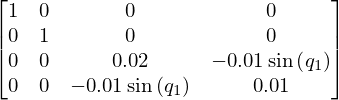

In [75]:
mass_open = kane.mass_matrix_full
mass_open

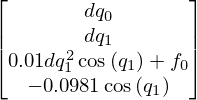

In [76]:
force_open = kane.forcing_full
force_open

## Recasting the dynamics

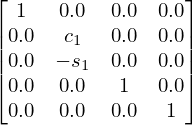

In [77]:
recast_transformation=sm.Matrix(np.zeros((3*n+2, 2*n+2)))
recast_transformation[0,0]=sm.S(1)
for i in range(n):
    recast_transformation[2*i+1,i+1] = cosstates[i]
    recast_transformation[2*i+2,i+1] = - sinstates[i]
for i in range(n+1):
    recast_transformation[-i-1,-i-1] = sm.S(1)
recast_transformation

In [37]:
from sympy import sin, cos
sins=[sin(i) for i in q[1:]]
coss=[cos(i) for i in q[1:]]
key = sins+coss
values = sinstates + cosstates
recast_sim_dict = dict(zip(key,values))

In [38]:
recast_sim_dict

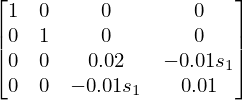

In [79]:
recast_mass = mass_open.subs(recast_sim_dict)
recast_mass

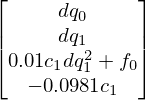

In [80]:
recast_force = sm.expand_trig(force_open).subs(dict(zip(key,values)))
recast_force

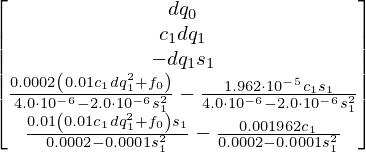

In [81]:
open_f_orig = recast_mass.inv()@recast_force
open_f_orig
# print(recast_mass.subs(recast_fix_point_dict))
# recast_force.subs(recast_fix_point_dict)
open_f_recast = recast_transformation@open_f_orig
open_f_recast

In [108]:
AA = open_f_recast.jacobian(recast_states).subs(recast_fix_point_dict).subs(dict(zip(f,np.zeros(n))))
AA = sm.matrix2numpy(AA,dtype=float)
AA.shape

In [109]:
BB = open_f_recast.jacobian(f).subs(recast_fix_point_dict)
BB = sm.matrix2numpy(BB,dtype=float)
BB.shape

In [111]:
from scipy.linalg import solve_continuous_are
QQ = 10*np.eye(AA.shape[0])
RR = np.eye(BB.shape[1])
SS = solve_continuous_are(AA, BB, QQ, RR);
KK = np.dot(np.dot(np.linalg.inv(RR), BB.T),  SS)
KK

LinAlgError: Failed to find a finite solution.

### symbolic transformation of the dyanmics, involing mass inversion, bad

Controller Design
=================

The n-link pendulum can be balanced such that all of the links are inverted above the cart by applying the correct lateral force to the cart. We can design a full state feedback controller based from a linear model of the pendulum about its upright equilibrium point. We'll start by specifying the equilibrium point and parameters in dictionaries. We make sure to use SymPy types in the equilibrium point to ensure proper cancelations in the linearization.

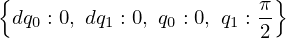

In [89]:
equilibrium_point = [sm.S(0)] + [sm.pi / 2] * (len(q) - 1) + [sm.S(0)] * len(u)                           
equilibrium_dict = dict(zip(q + u, equilibrium_point))
equilibrium_dict

The `KanesMethod` class has method that linearizes the forcing vector about generic state and input perturbation vectors. The equilibrium point and numerical constants can then be substituted in to give the linear system in this form: $M\dot{x}=F_Ax+F_Br$. The state and input matrices, $A$ and $B$, can then be computed by left side multiplication by the inverse of the mass matrix: $A=M^{-1}F_A$ and $B=M^{-1}F_B$.

In [90]:
M, F_A, F_B, r = kane.linearize(new_method=True, op_point=equilibrium_dict)

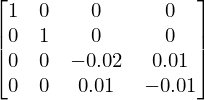

In [91]:
sm.simplify(M)

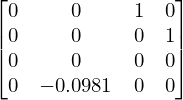

In [92]:
sm.simplify(F_A)

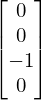

In [93]:
sm.simplify(F_B)

Now the numerical $A$ and $B$ matrices can be formed. First substitute numerical parameter values into $M$, $F_A$, and $F_B$.

In [94]:
parameter_dict = dict(zip(parameters, parameter_vals))
parameter_dict

In [95]:
M_num = sm.matrix2numpy(M.subs(parameter_dict), dtype=float)
F_A_num = sm.matrix2numpy(F_A.subs(parameter_dict), dtype=float)
F_B_num = sm.matrix2numpy(F_B.subs(parameter_dict), dtype=float)
A = np.linalg.solve(M_num, F_A_num)
B = np.linalg.solve(M_num ,F_B_num)

In [96]:
print(A)

[[ 0.    0.    1.    0.  ]
 [ 0.    0.    0.    1.  ]
 [-0.    9.81 -0.   -0.  ]
 [-0.   19.62 -0.   -0.  ]]


In [97]:
print(B)

[[  0.]
 [  0.]
 [100.]
 [100.]]


Also convert `equilibrium_point` to a numeric array:

In [126]:
equilibrium_point = np.asarray([x.evalf() for x in equilibrium_point], dtype=float)

Now that we have a linear system, the SciPy package can be used to design an optimal controller for the system.

So now we can compute the optimal gains with a linear quadratic regulator. I chose identity matrices for the weightings for simplicity.

In [127]:
from scipy.linalg import solve_continuous_are
Q = np.eye(A.shape[0])
R = np.eye(B.shape[1])
S = solve_continuous_are(A, B, Q, R);
K = np.dot(np.dot(np.linalg.inv(R), B.T),  S)
K

array([[-1.        ,  9.61514829, -1.70888118,  3.18275463]])

The gains can now be used to define the required input during simulation to stabilize the system. The input $r$ is simply the gain vector multiplied by the error in the state vector from the equilibrium point, $r(t)=K(x_{eq} - x(t))$.

In [128]:
def right_hand_side(x, t, args):
    """Returns the derivatives of the states.

    Parameters
    ----------
    x : ndarray, shape(2 * (n + 1))
        The current state vector.
    t : float
        The current time.
    args : ndarray
        The constants.

    Returns
    -------
    dx : ndarray, shape(2 * (n + 1))
        The derivative of the state.
    
    """
    div = equilibrium_point - x
    div[:n+1] = np.sin(div[:n+1])
    r = np.dot(K, div)    # The controller   
    arguments = np.hstack((x, r))     # States, input, and parameters
    dx = np.array(solve(M_func(*arguments), # Solving for the derivatives
                        f_func(*arguments))).T[0]
    
    return dx

Now we can simulate and animate the system to see if the controller works.

In [129]:
if do_plot:
    x0 = np.hstack((0,
                (np.pi/ 2) * np.ones(len(q) - 1) - np.random.uniform(-.3,.2,(len(q) - 1)),
                2* np.ones(len(u))))
    t = np.linspace(0.0, 10.0, num=500)
    x = odeint(right_hand_side, x0, t, args=(parameter_vals,))

The plots show that we seem to have a stable system.

In [130]:
if do_plot:
    lines = plt.plot(t, x[:, :x.shape[1] // 2])
    lab = plt.xlabel('Time [sec]')
    leg = plt.legend(dynamic[:x.shape[1] // 2])

In [131]:
if do_plot:
    lines = plt.plot(t, x[:, x.shape[1] // 2:])
    lab = plt.xlabel('Time [sec]')
    leg = plt.legend(dynamic[x.shape[1] // 2:])

In [132]:
if do_sim:
    anim = animate_pendulum(t, x, arm_length)

    # Set up formatting for the movie files
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

    anim.save('closed-loop.mp4',writer = 'ffmpeg')

In [133]:
if do_sim:
    from IPython.display import HTML
    html = \
    """
    <video width="640" height="480" controls>
      <source src="closed-loop.mp4" type="video/mp4">
    Your browser does not support the video tag, check out the YouTube version instead: http://youtu.be/SpgBHqW9om0
    </video>
    """
    HTML(html)

### Feedback the LQR controller for the closed-loop EOM:

In [134]:
states = np.array(q + u)
div = equilibrium_point - states
div

array([-q0(t), 1.5707963267949 - q1(t), -dq0(t), -dq1(t)], dtype=object)

### Turn the feedback on the small angle $\theta$ to feedback on the $\sin(\theta)$

In [135]:
from sympy import sin, cos
div_in_trig = div
for i in range(n):
    div_in_trig[i+1] = sin(div[i+1])
div_in_trig

array([-q0(t), -sin(q1(t) - 1.5707963267949), -dq0(t), -dq1(t)],
      dtype=object)

In [136]:
feedback = np.dot(K, div_in_trig)

forces = [(P0, feedback[0] * I.x - m[0] * g * I.y)] # List to hold the n + 1 applied forces, including the input force, f

for i in range(n):
    forces.append((Pi, -m[i + 1] * g * I.y))                  # Set the force applied at the point
for i in range(n-1):
    forces.append((frames[i+1], feedback[i+1]*frames[i].z))

kane_cl = me.KanesMethod(I, q_ind=q, u_ind=u, kd_eqs=kindiffs)
fr_cl, frstar_cl = kane_cl.kanes_equations(forces, particles)

/Users/shenshen/veril/ENV/lib/python3.7/site-packages/sympy/physics/mechanics/kane.py:536: SymPyDeprecationWarning: 

The kanes_equation() argument order has been deprecated since SymPy
1.1. Use switched argument order to update your code, For example:
kanes_equations(loads, bodies) > kanes_equations(bodies, loads).
instead. See https://github.com/sympy/sympy/issues/10945 for more
info.  The API for kanes_equations() has changed such that the loads
(forces and torques) are now the second argument and is optional with
None being the default.

  issue=10945, deprecated_since_version="1.1").warn()


In [137]:
massmatrix = (kane_cl.mass_matrix)
forcesmatrix = (kane_cl.forcing)

### Double check the EOM is in terms of the trigs and velocities only

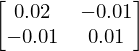

In [170]:
massmatrix.subs(equilibrium_dict)

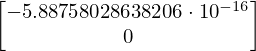

In [172]:
forcesmatrix.subs(equilibrium_dict)

Expand trig of angle differnce into absolute angle trigs

In [140]:
# sm.expand_trig(forcesmatrix)

### Double check the CL dynamics in terms of $q$ $\dot q$ are stable

In [141]:
M_cl, F_A_cl, F_B_cl, r_cl = kane_cl.linearize(new_method=True, op_point=equilibrium_dict)
M_num_cl = sm.matrix2numpy(M_cl, dtype=float)
F_A_num_cl = sm.matrix2numpy(F_A_cl, dtype=float)
A_cl = np.linalg.solve(M_num_cl, F_A_num_cl)
A_cl

array([[   0.        ,    0.        ,    1.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,    1.        ],
       [ 100.        , -951.70482868,  170.88811779, -318.27546344],
       [ 100.        , -941.89482868,  170.88811779, -318.27546344]])

In [142]:
np.linalg.eig(A_cl)[0]
from scipy.linalg import solve_lyapunov
P = solve_lyapunov(A_cl.T, -np.eye(A_cl.shape[0]))

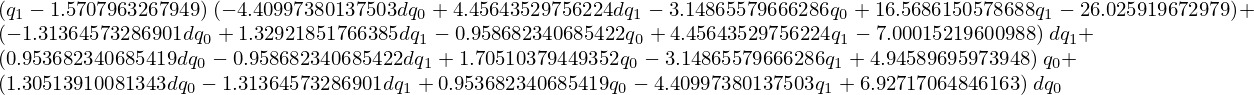

In [143]:
orig_basis = states - equilibrium_point
V = ((orig_basis).T@P@(orig_basis))
V
# sm.N(V.subs(equilibrium_dict))
# orig_basis

#### Recasting the Lyapunov Method 1 (angle replacement)

In [148]:
# first recast small angle squared

# small_squared = [i**2 for i in q[1:]]
# small_squared_cos = [2-2*i for i in cosstates]
# recat_lyap_dict = dict(zip(small_squared,small_squared_cos))
# V_recast = V.subs(recat_lyap_dict)

In [149]:
# next recast the small angle themselves

# V_recast = V_recast.subs(dict(zip(q[1:],sinstates)))
# V_recast

#### Recasting the Lyapunov Method 2 (direct replacement)

In [150]:
recast_basis = [q[0]] + sinstates + u
V_recast = sm.expand(recast_basis@P@recast_basis)

In [151]:
small_squared_cos = [2-2*i for i in cosstates]
# recast_basis_one = [q[0]] + sinstates + u
# V1 = sm.expand(recast_basis@P@recast_basis)
# me.find_dynamicsymbols(V_recast)
small_squared_cos
V_recast.subs(recast_fix_point_dict)

### do linearization in the [s,c,t] coordinate, getting non-Hurwitz A, so go back to small-angle approx. of V

In [165]:
ddq = recast_mass.inv()@recast_force  ## doubledots(q) expressed in q, dq
dsdc = recast_transformation@ddq 

# dynamics_recast = sm.Matrix([dq0, dsdc, ddq])
# dynamics_recast.shape

dsdc_A = sm.matrix2numpy(dsdc.jacobian(recast_states).subs(recast_fix_point_dict), dtype=float)
ddq_A = sm.matrix2numpy(ddq.jacobian(recast_states).subs(recast_fix_point_dict), dtype=float)

In [166]:
dq0_A = np.zeros(2*n+2+n)
dq0_A[-n-1]=1
A_recast = np.vstack((dq0_A, dsdc_A,ddq_A))
A_recast

array([[   0.        ,    0.        ,    0.        ,    1.        ,
           0.        ],
       [   0.        ,  480.75741434,  -19.62      ,    0.        ,
           0.        ],
       [   0.        ,    9.81      ,    0.        ,    0.        ,
           0.        ],
       [  50.        ,   -4.905     ,  480.75741434,   85.44405889,
        -159.13773172],
       [   0.        ,  480.75741434,   -9.81      ,    0.        ,
           0.        ]])

In [158]:
np.linalg.eig(A_recast)[0]

array([-5.81224473e-01,  8.60252834e+01,  4.80356728e+02,  4.00685967e-01,
        4.40251232e-14])

In [159]:
# P = solve_lyapunov(A_recast.T, -np.eye(A_recast.shape[0]))
# np.linalg.eig(P)[0]

In [160]:
# direc_v_recast = sm.simplify((recast_states - recast_fix_point).T@P@(recast_states - recast_fix_point))
# direc_v_recast

In [161]:
# import sys
# sys.path.append(
#     "/Users/shenshen/drake-build/install/lib/python3.7/site-packages")
# from pydrake.all import (Polynomial, Variable, Evaluate, Substitute,
#                          MathematicalProgram, MosekSolver)

In [162]:
def sample():
    alpha= np.random.randn(2*n+2)
    beta = np.random.randn(2*n+2)
    t = sm.Symbol('t',real=True)
    old_states_dict = dict(zip(states, alpha*t+beta))
#     old_states_dict

    angle = np.random.uniform(-.2,.2,n)
    sin_samples, cos_samples = np.sin(angle), np.cos(angle)
    trig_sample_dict = dict(zip(sinstates + cosstates, np.concatenate([sin_samples, cos_samples])))
#     trig_sample_dict
    phi = V_recast.diff((recast_states,1))
    this_phi = sm.simplify(phi.subs(old_states_dict).subs(trig_sample_dict))
#     this_phi.shape
    this_mass = sm.matrix2numpy(sm.simplify(recast_mass.subs(old_states_dict).subs(trig_sample_dict)),dtype=float)
    this_mass_inv = np.linalg.inv(this_mass)
#     this_mass_inv

    this_force = sm.matrix2numpy(sm.simplify(recast_force.subs(old_states_dict).subs(trig_sample_dict)))
#     this_force

    this_ddq = this_mass_inv@this_force
#     this_ddq.shape

    this_recast_transform = sm.matrix2numpy(recast_transformation.subs(trig_sample_dict),dtype=float)
    this_dsdc = this_recast_transform@this_ddq
#     this_dsdc

    this_dq0=old_states_dict[u[0]]
    this_f = np.vstack((this_dq0, this_dsdc, this_ddq))
    this_Vdot = this_phi@this_f

    t_num=sm.solve(this_Vdot,t)
    if len(t_num)>0:
        print('found root')
        old_states_num_dict = dict(zip(states, alpha*t_num+beta))
        return angle, t_num, old_states_num_dict
    else:
        print('no root')

In [163]:
for i in range(100):
    sample()

no root
no root
no root
no root
no root
no root
no root
no root
no root
no root
no root
no root
no root
no root
found root
found root
no root
no root
found root
no root
no root
no root
no root
no root
no root
no root
no root
no root
no root
no root
no root
found root
no root
no root
no root
found root
no root
found root
no root
no root
no root
no root


KeyboardInterrupt: 